In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 5.0 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [49]:
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Point

def plotar_mapa_com_pois(grafo, pois, margem=0.01):
    """
    Plota o grafo com as praias extraídas do OSM, ajustando a área de visualização automaticamente.
    """

    print("🔍 Preparando dados para o plot...")

    # Substituir geometrias que não são Point por seus centroides
    pois['geometry'] = pois['geometry'].apply(
        lambda g: g.centroid if g.geom_type != 'Point' else g
    )

    # Filtrar apenas as praias com geometria válida
    praia = pois[pois.geometry.type == 'Point']

    if praia.empty:
        print("⚠️ Nenhuma praia com geometria válida foi encontrada para plotar.")
        return

    # Coordenadas das praias
    lats = praia.geometry.y
    lons = praia.geometry.x

    # Calcular limites do mapa
    min_lat, max_lat = lats.min() - margem, lats.max() + margem
    min_lon, max_lon = lons.min() - margem, lons.max() + margem

    print(f"🗺️ Plotando mapa de Natal com {len(praia)} praias...")
    fig, ax = plt.subplots(figsize=(16, 12))

    # Plotar o grafo
    ox.plot_graph(
        grafo,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False
    )

    # Plotar as praias
    praia.plot(
        ax=ax,
        color='darkred',
        markersize=40,
        marker='o',
        alpha=0.8,
        label=f'praias ({len(praia)})'
    )

    # Ajustes visuais
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.set_title("Mapa praias de Natal - RN", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [50]:
def plotar_mst_praias(grafo, pois, mst_edges, praia_nodes, margem=0.01):
    """
    Plota o grafo da cidade com as praias e destaca as rotas da MST em vermelho.

    - grafo: grafo viário (networkx.MultiDiGraph)
    - pois: GeoDataFrame com praias
    - mst_edges: lista de arestas da MST, formato [(u,v,d), ...]
    - praia_nodes: lista dos nós do grafo mais próximos das praias
    """

    # Preparar Praias (pontos ou centroides)
    pois['geometry'] = pois['geometry'].apply(
        lambda g: g.centroid if g.geom_type != 'Point' else g
    )
    praia = pois[pois.geometry.type == 'Point']

    if praia.empty:
        print("⚠️ Nenhuma praia válida para plotar.")
        return

    lats = praia.geometry.y
    lons = praia.geometry.x

    min_lat, max_lat = lats.min() - margem, lats.max() + margem
    min_lon, max_lon = lons.min() - margem, lons.max() + margem

    print(f"🗺️ Plotando mapa com {len(praia)} praias e MST...")

    fig, ax = plt.subplots(figsize=(16, 12), dpi=100)

    # Plotar grafo base
    ox.plot_graph(
        grafo,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False
    )

    # Plotar MST em vermelho
    for (u, v, d) in mst_edges:
        route = nx.shortest_path(grafo, u, v, weight='length')
        x = [grafo.nodes[n]['x'] for n in route]
        y = [grafo.nodes[n]['y'] for n in route]
        ax.plot(x, y, color='red', linewidth=2, zorder=4)

    # Plotar praias em azul
    poi_x = [grafo.nodes[n]['x'] for n in praia_nodes]
    poi_y = [grafo.nodes[n]['y'] for n in praia_nodes]
    ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='praias')

    # Ajustes visuais
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.set_title("Mapa praias de Natal - RN com MST", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [3]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [4]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [32]:
# ============================================
# 2. Obter POIs de interesse (hospitais como exemplo)
# ============================================
tags = {'natural': 'beach'}
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
beachs = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        beachs.append((row.geometry.y, row.geometry.x))
    else:
        beachs.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not beachs:
    print("Nenhum hospital encontrado. Tentando escolas...")
    tags = {'amenity': 'school'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
            beachs.append((row.geometry.y, row.geometry.x))
        else:
            beachs.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not beachs:
        raise ValueError("Nenhum POI encontrado para as categorias tentadas.")

In [57]:
pois

geometry natural                  name  \
element  id                                                                    
relation 397020     POINT (-35.17388 -5.87553)   beach  Praia de Ponta Negra   
         414254     POINT (-35.18118 -5.82973)   beach          Via Costeira   
         414842     POINT (-35.20141 -5.75871)   beach            Praia do Y   
         2417182    POINT (-35.20275 -5.75296)   beach                   NaN   
         2449648    POINT (-35.18994 -5.78417)   beach                   NaN   
         2449649    POINT (-35.18756 -5.79015)   beach                   NaN   
         2449650    POINT (-35.18536 -5.79235)   beach                   NaN   
         2449651    POINT (-35.18928 -5.78681)   beach                   NaN   
         13237206   POINT (-35.20787 -5.75851)   beach                   NaN   
         18982298    POINT (-35.2039 -5.74696)   beach                   NaN   
         18982300   POINT (-35.20396 -5.74053)   beach                   NaN   
way      41312227   POINT (-35.19519 -5.75538)   beach                   NaN   
         41312228   POINT (-35.19557 -5.76081)   beach        Praia do Forte   
         41312231    POINT (-35.19432 -5.7739)   beach         Praia do Meio   
         41312232   POINT (-35.19297 -5.78009)   beach    Praia dos Artistas   
         129549999  POINT (-35.22267 -5.84376)   beach                   NaN   
         184014538  POINT (-35.20263 -5.75064)   beach               Redinha   

                    wikidata          wikimedia_commons  \
element  id                                               
relation 397020     Q2330338                        NaN   
         414254          NaN                        NaN   
         414842          NaN                        NaN   
         2417182    Q7305959                        NaN   
         2449648         NaN                        NaN   
         2449649         NaN                        NaN   
         2449650         NaN                        NaN   
         2449651         NaN                        NaN   
         13237206        NaN                        NaN   
         18982298        NaN                        NaN   
         18982300        NaN                        NaN   
way      41312227        NaN                        NaN   
         41312228        NaN                        NaN   
         41312231        NaN                        NaN   
         41312232        NaN                        NaN   
         129549999       NaN                        NaN   
         184014538  Q7305959  Category:Praia da Redinha   

                                          wikipedia          type  \
element  id                                                         
relation 397020     pt:Praia de Ponta Negra (Natal)  multipolygon   
         414254                                 NaN  multipolygon   
         414842                                 NaN  multipolygon   
         2417182                pt:Praia da Redinha  multipolygon   
         2449648                                NaN  multipolygon   
         2449649                                NaN  multipolygon   
         2449650                                NaN  multipolygon   
         2449651                                NaN  multipolygon   
         13237206                               NaN  multipolygon   
         18982298                               NaN  multipolygon   
         18982300                               NaN  multipolygon   
way      41312227                               NaN           NaN   
         41312228                               NaN           NaN   
         41312231                               NaN           NaN   
         41312232                               NaN           NaN   
         129549999                              NaN           NaN   
         184014538              pt:Praia da Redinha           NaN   

                        name:en              alt_name salt  \
element  id          

In [33]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in beachs]
longitudes = [hp[1] for hp in beachs]
beachs_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
beachs_nodes = list(set(beachs_nodes))

if len(beachs_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

In [34]:
len(beachs)

17

🔍 Preparando dados para o plot...
🗺️ Plotando mapa de Natal com 17 praias...


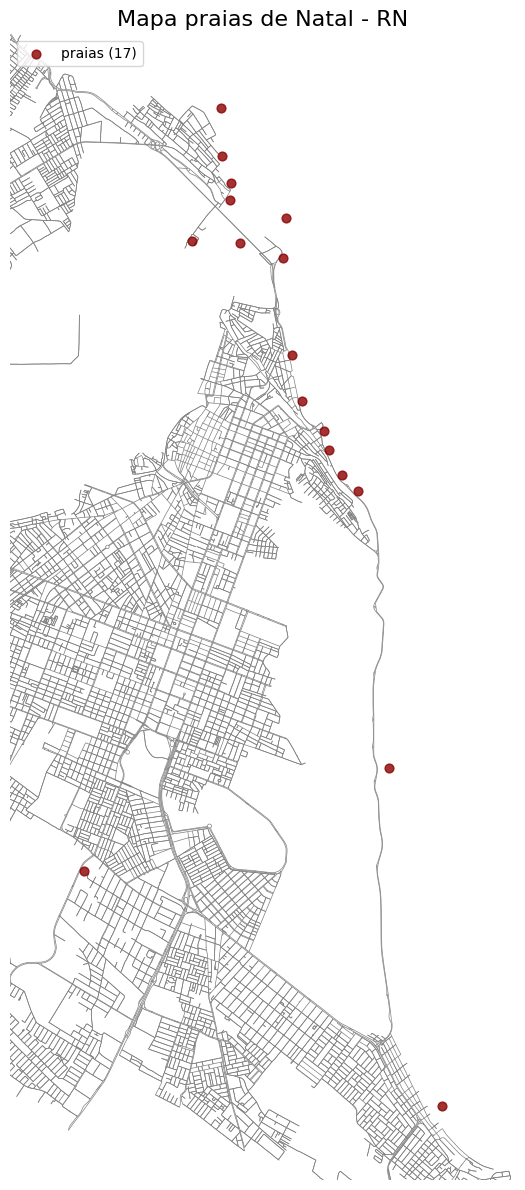

In [51]:
plotar_mapa_com_pois(G, pois)

In [52]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(beachs_nodes)):
    for j in range(i+1, len(beachs_nodes)):
        route = nx.shortest_path(G_undirected, beachs_nodes[i], beachs_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(beachs_nodes[i], beachs_nodes[j], weight=route_length)

In [53]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 28028.273009249802 metros


🗺️ Plotando mapa com 17 praias e MST...


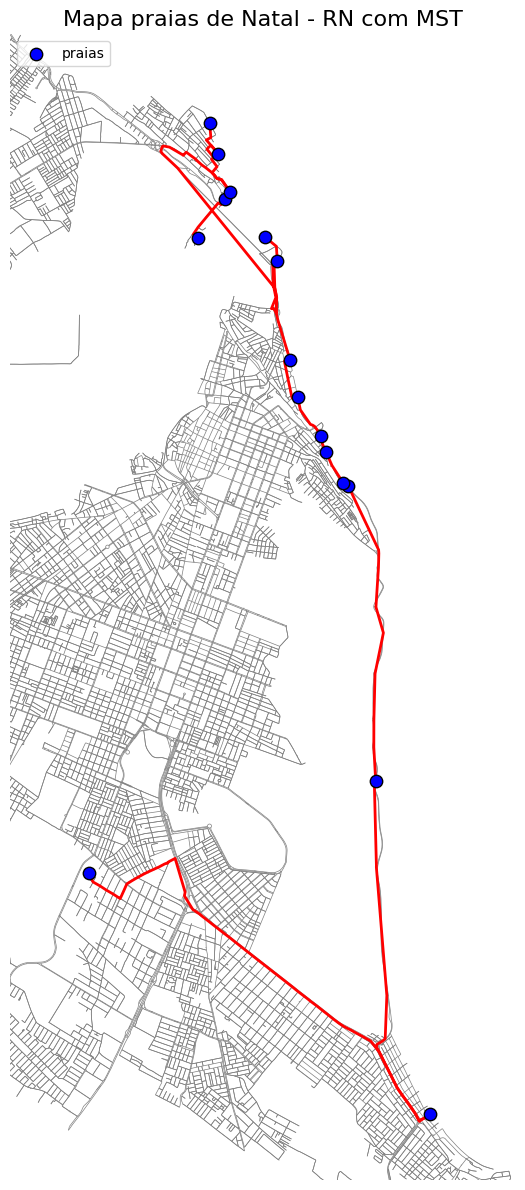

In [54]:
plotar_mst_praias(G, pois, mst_edges, beachs_nodes, margem=0.01)